In [1]:
!pip -q install ftfy regex tqdm
!pip -q install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00


In [2]:
## Download sample dataset for testing.
# Each class contains 10 images for quick evaluation.
!gdown 18paJR61S5InkKmb_VhiGY2Wx0HNBEd-q

Downloading...
From (original): https://drive.google.com/uc?id=18paJR61S5InkKmb_VhiGY2Wx0HNBEd-q
From (redirected): https://drive.google.com/uc?id=18paJR61S5InkKmb_VhiGY2Wx0HNBEd-q&confirm=t&uuid=1dd05706-ea06-414f-9561-0b79abe0c52f
To: /content/sample_v2.zip
100% 39.5M/39.5M [00:01<00:00, 30.6MB/s]


In [3]:
# Download our trained model
!gdown 1XggxTZzXNd2JIzOIjCYYc4HVoH3SBQeM

Downloading...
From: https://drive.google.com/uc?id=1XggxTZzXNd2JIzOIjCYYc4HVoH3SBQeM
To: /content/vf_model.pth
100% 4.36M/4.36M [00:00<00:00, 66.7MB/s]


In [4]:
!unzip -q sample_v2.zip

In [5]:
import os
import torch
import clip
import torch.nn.functional as F
import random
import numpy as np
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image

from tqdm import tqdm
import torch.nn.init as init

In [6]:
embed_dim = 512
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=10.0):
        super().__init__()
        # Fixed random weights for projecting scalar t to higher frequency space
        self.W = nn.Parameter(torch.randn(1, embed_dim // 2) * scale, requires_grad=False)

    def forward(self, t):
        # Ensure t has shape [B, 1]
        if t.ndim == 1:
            t = t.unsqueeze(-1)
        proj = t * self.W  # Shape: [B, D/2]
        # Return sinusoidal and cosinusoidal projection: [sin(tW), cos(tW)] → Shape: [B, D]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class VectorField(nn.Module):
    def __init__(self, dim, t_dim=32, hidden_dim=256, n_heads=4, dropout_prob=0.1):
        super().__init__()
        self.x_norm = nn.LayerNorm(dim)  # Normalize input embeddings
        self.time_encoder = GaussianFourierProjection(t_dim)  # Time embedding module
        self.dropout = nn.Dropout(dropout_prob)

        # Create multiple independent heads (like a lightweight transformer block)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim + t_dim, hidden_dim),     # Project input + time
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),                               # Activation: SiLU
                nn.Dropout(dropout_prob),
                nn.Linear(hidden_dim, dim)              # Back to original embedding dimension
            ) for _ in range(n_heads)
        ])

        self.res_weight = nn.Parameter(torch.tensor(1.0))  # Learnable residual scaling
        self.out_norm = nn.LayerNorm(dim)  # Final normalization (not applied directly here)
        self.initialize_weights()


    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Use Kaiming initialization (good for ReLU/SiLU)
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)


    def forward(self, x, t):
        # Handle scalar or 1D tensor time input → ensure shape [B, 1]
        if not isinstance(t, torch.Tensor):
            t = torch.full((x.shape[0], 1), t, device=x.device)
        elif t.ndim == 0:
            t = t.expand(x.shape[0], 1)
        elif t.ndim == 1:
            t = t.unsqueeze(-1)

        x_normed = self.x_norm(x)                     # Normalize input
        t_encoded = self.time_encoder(t.to(x.device)) # Encode time t
        inp = torch.cat([x_normed, t_encoded], dim=-1)  # Concatenate along feature dim

        # Pass through each head and average their outputs
        head_outs = [head(inp) for head in self.heads]
        out = torch.mean(torch.stack(head_outs), dim=0)

        # Add residual connection scaled by learnable weight
        return out + self.res_weight * x

In [7]:
def euler_integration(x0, vf, steps=10):
    """
    Args:
        x0: initial embeddings [B, D]
        vf: vector field model (takes in x and t, returns dx/dt)
        steps: number of integration steps
    Returns:
        Transformed embeddings x(T)
    """
    if steps == 0:
      x = vf(x0, t=torch.tensor([[0.0]], device=emb.device)).squeeze(0).cpu()
    else:
      dt = 1.0 / steps
      x = x0
      for i in range(steps):
          t = i * dt
          k1 = vf(x, t)
          k2 = vf(x + 0.5 * dt * k1, t + 0.5 * dt)
          k3 = vf(x + 0.5 * dt * k2, t + 0.5 * dt)
          k4 = vf(x + dt * k3, t + dt)
          x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load pre-trained CLIP model (ViT-B/32) for image embedding
model, preprocess = clip.load("ViT-B/32", device=device)

# Initialize the learned time-dependent vector field module
vf = VectorField(embed_dim).to(device).float()

# Load the pre-trained weights for the vector field
vf.load_state_dict(torch.load("./vf_model.pth", map_location=device))
vf.eval()  # Set to evaluation mode

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 31.6MiB/s]


VectorField(
  (x_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (time_encoder): GaussianFourierProjection()
  (dropout): Dropout(p=0.1, inplace=False)
  (heads): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=544, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=256, out_features=512, bias=True)
    )
  )
  (out_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [26]:
import os
import torch
import numpy as np
from PIL import Image
from glob import glob
from sklearn.metrics.pairwise import cosine_similarity

# === Configuration ===
query_path = "/content/sample_v2/ear-left/23078994_230405081302497831_121_image02.png"
dataset_dir = "/content/sample_v2"
steps = 0  # Number of integration steps for vector field transformation

# === Function to get image embedding ===

def get_embedding(img_path, steps=0):
    img = Image.open(img_path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(tensor)
        emb = emb / emb.norm(dim=-1, keepdim=True)  # Normalize to unit vector

        #emb = emb.to(next(vf.parameters()).dtype)


        if steps != 0:
          emb = euler_integration(emb, vf, steps)
        else:
           emb = vf(emb, t=torch.tensor([[0.0]], device=emb.device)).squeeze(0).cpu()



    return emb.squeeze(0).detach().cpu().numpy()


# === Get query image embedding ===
query_emb = get_embedding(query_path,  steps=steps).reshape(1, -1)

# === Load all image paths from dataset ===
image_paths = glob(os.path.join(dataset_dir, "**", "*.png"), recursive=True)
print("Found", len(image_paths), "images.")

# === Compute embeddings for all images in dataset ===
embeddings, valid_paths = [], []
for path in image_paths:
    try:
        emb = get_embedding(path, steps=steps)
        embeddings.append(emb)
        valid_paths.append(path)
    except Exception as e:
        print(f"Failed to process {path}: {e}")

# === Compute cosine similarity between query and dataset embeddings ===
embeddings = np.stack(embeddings)
sims = cosine_similarity(query_emb, embeddings)[0]

# === Remove the query image itself from results ===
for i, path in enumerate(valid_paths):
    if os.path.abspath(path) == os.path.abspath(query_path):
        sims[i] = -1.0

# === Retrieve top-5 most similar images ===
top5_idx = np.argsort(sims)[-5:][::-1]
print("\nTop 5 most similar images:")
for i in top5_idx:
    print(f"{valid_paths[i]} - Score: {sims[i]:.4f}")


Found 70 images.

Top 5 most similar images:
/content/sample_v2/ear-right/9a299ef6-39e7-410c-92cb-37f95980a38d.png - Score: 0.8390
/content/sample_v2/ear-right/7e0c078a-e77b-4be1-b614-5a47044b1d4a.png - Score: 0.8252
/content/sample_v2/ear-left/71736890-0247-45ce-a692-60908a972a06.png - Score: 0.8226
/content/sample_v2/ear-right/0f70e420-67d9-46c7-a253-ae20702c07fd.png - Score: 0.7651
/content/sample_v2/ear-left/3fe5993d-3af6-4d94-bb8b-444319ee2fe3.png - Score: 0.7628


Saved to retrieval_result.pdf


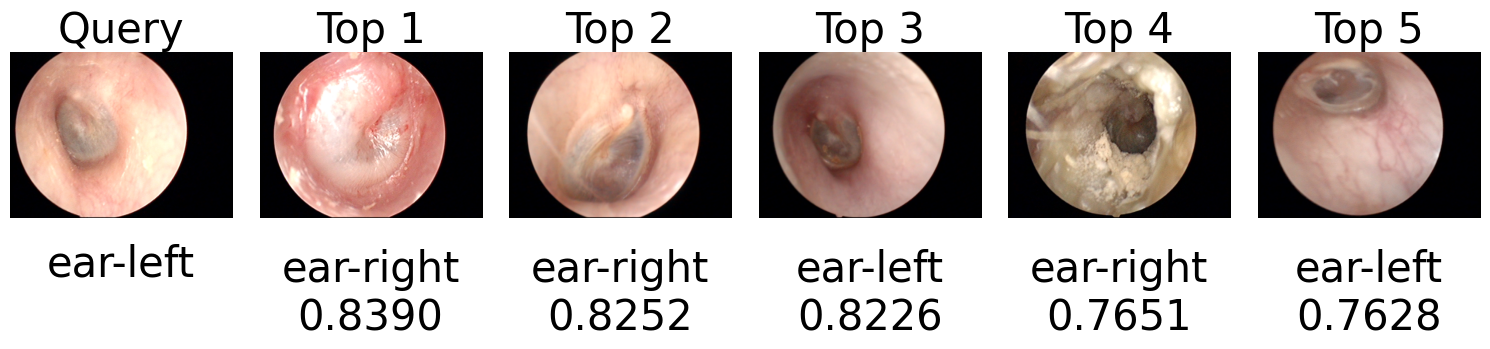

In [27]:
def show_query_and_topk_row(query_path, valid_paths, sims, k=10, save_path=None):
    plt.figure(figsize=(k * 3, 4.5))

    # Hiển thị query
    query_img = Image.open(query_path).convert("RGB")
    query_class = get_class_name_from_path(query_path)
    plt.subplot(1, k + 1, 1)
    plt.imshow(query_img)
    plt.axis("off")
    plt.title("Query", fontsize=30)
    plt.text(0.5, -0.15, f"{query_class}", fontsize=30, ha='center', va='top', transform=plt.gca().transAxes)

    # Hiển thị top-k
    topk_idx = np.argsort(sims)[-k:][::-1]
    for i, idx in enumerate(topk_idx):
        img_path = valid_paths[idx]
        img = Image.open(img_path).convert("RGB")
        class_name = get_class_name_from_path(img_path)
        score = sims[idx]

        plt.subplot(1, k + 1, i + 2)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Top {i+1}", fontsize=30)
        plt.text(0.5, -0.18, f"{class_name}\n{score:.4f}", fontsize=30,
                 ha='center', va='top', transform=plt.gca().transAxes)

    plt.tight_layout()

    # ✅ Lưu PDF nếu cần
    if save_path:
        plt.savefig(save_path, dpi=300, format="pdf", bbox_inches="tight")
        print(f"Saved to {save_path}")
    else:
        plt.show()
import os
import matplotlib.pyplot as plt
from PIL import Image
def get_class_name_from_path(path):
    return os.path.basename(os.path.dirname(path))
show_query_and_topk_row(
    query_path,
    valid_paths,
    sims,
    k=5,
    save_path="retrieval_result.pdf"
)
